In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

## Data Preprocessing

In [96]:
Weather = pd.read_csv("dataset/produkt_tu_stunde_19480101_20231231_05906.txt", delimiter=";")
Weather

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,5906,1948010101,5,-0.3,90.0,eor
1,5906,1948010102,5,-0.3,89.0,eor
2,5906,1948010103,5,0.1,89.0,eor
3,5906,1948010104,5,0.5,91.0,eor
4,5906,1948010105,5,0.8,87.0,eor
...,...,...,...,...,...,...
666127,5906,2023123119,3,6.8,79.0,eor
666128,5906,2023123120,3,7.2,77.0,eor
666129,5906,2023123121,3,7.2,76.0,eor
666130,5906,2023123122,3,6.7,78.0,eor


In [97]:
print(set(Weather['STATIONS_ID']))
print(set(Weather['eor']))

{5906}
{'eor'}


All data was recorded in the same Mannheim weather station, thus we can remove the redundant columns. We will also drop the quality of the weather measurement ("QN_9").

In [98]:
Weather = Weather.drop(columns=['STATIONS_ID', 'eor', 'QN_9'])

Weather['MESS_DATUM'] = pd.to_datetime(Weather['MESS_DATUM'], format='%Y%m%d%H')  # conver to proper time format

Weather

,MESS_DATUM,TT_TU,RF_TU
0,1948-01-01 01:00:00,-0.3,90.0
1,1948-01-01 02:00:00,-0.3,89.0
2,1948-01-01 03:00:00,0.1,89.0
3,1948-01-01 04:00:00,0.5,91.0
4,1948-01-01 05:00:00,0.8,87.0
...,...,...,...
666127,2023-12-31 19:00:00,6.8,79.0
666128,2023-12-31 20:00:00,7.2,77.0
666129,2023-12-31 21:00:00,7.2,76.0
666130,2023-12-31 22:00:00,6.7,78.0


In those 76 years of measurement some a few dozen entries are inevitable missing due to error. We will interpolate them using the mean of the surrounding entries.

In [99]:
Weather = Weather.set_index('MESS_DATUM')

# Resample the DataFrame to hourly frequency to identify missing timestamps
Weather = Weather.resample('h').asfreq()

Weather['TT_TU'] = Weather['TT_TU'].interpolate(method='linear')
Weather['RF_TU'] = Weather['RF_TU'].interpolate(method='linear')

Weather = Weather.reset_index()
Weather

,MESS_DATUM,TT_TU,RF_TU
0,1948-01-01 01:00:00,-0.3,90.0
1,1948-01-01 02:00:00,-0.3,89.0
2,1948-01-01 03:00:00,0.1,89.0
3,1948-01-01 04:00:00,0.5,91.0
4,1948-01-01 05:00:00,0.8,87.0
...,...,...,...
666210,2023-12-31 19:00:00,6.8,79.0
666211,2023-12-31 20:00:00,7.2,77.0
666212,2023-12-31 21:00:00,7.2,76.0
666213,2023-12-31 22:00:00,6.7,78.0


Now we have a preprocessed time series of air temperature in degree Celsius ("TT_TU") and relative humidity as a percentage ("RF_TU").

## Simple Regression Models

We will first try simple regression models to predict air temperature and humidity in 6 hours based on the current time and measurments of the last 10 hours.

In [100]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [101]:
# add last 10 entries to regression matrix X
lags = 10
forecast_shift = 5
X_a = np.zeros((len(Weather) - lags - forecast_shift, lags))
y_a = np.zeros(len(Weather) - lags - forecast_shift)

for i in range(lags, len(Weather) - forecast_shift):
    X_a[i - lags] = Weather['TT_TU'].iloc[i - lags:i].values
    y_a[i - lags] = Weather['TT_TU'].iloc[i + forecast_shift]

X = pd.DataFrame(X_a, columns=[f'TT_TU_lag_{i}' for i in range(lags, 0, -1)])
y = pd.Series(y_a, name='TT_TU')

X['Hour'] = Weather['MESS_DATUM'].iloc[lags:-forecast_shift].dt.hour.values
X['Days'] = Weather['MESS_DATUM'].iloc[lags:-forecast_shift].dt.dayofyear.values

X

,TT_TU_lag_10,TT_TU_lag_9,TT_TU_lag_8,TT_TU_lag_7,TT_TU_lag_6,TT_TU_lag_5,TT_TU_lag_4,TT_TU_lag_3,TT_TU_lag_2,TT_TU_lag_1,Hour,Days
0,-0.3,-0.3,0.1,0.5,0.8,0.8,0.7,0.6,1.1,1.0,11,1
1,-0.3,0.1,0.5,0.8,0.8,0.7,0.6,1.1,1.0,1.1,12,1
2,0.1,0.5,0.8,0.8,0.7,0.6,1.1,1.0,1.1,1.1,13,1
3,0.5,0.8,0.8,0.7,0.6,1.1,1.0,1.1,1.1,1.1,14,1
4,0.8,0.8,0.7,0.6,1.1,1.0,1.1,1.1,1.1,1.1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...
666195,5.7,5.5,6.5,7.6,7.2,7.9,8.4,8.7,8.4,8.8,14,365
666196,5.5,6.5,7.6,7.2,7.9,8.4,8.7,8.4,8.8,8.9,15,365
666197,6.5,7.6,7.2,7.9,8.4,8.7,8.4,8.8,8.9,8.2,16,365
666198,7.6,7.2,7.9,8.4,8.7,8.4,8.8,8.9,8.2,7.9,17,365


To improve the training we scale all columns with the standard scaler of `sklearn`.

In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# scale y after conversion to nx1 matrix
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y_scaled = pd.Series(y_scaled.flatten(), name=y.name)

X_scaled

,TT_TU_lag_10,TT_TU_lag_9,TT_TU_lag_8,TT_TU_lag_7,TT_TU_lag_6,TT_TU_lag_5,TT_TU_lag_4,TT_TU_lag_3,TT_TU_lag_2,TT_TU_lag_1,Hour,Days
0,-0.581240,-0.581241,-0.559593,-0.537944,-0.521708,-0.521709,-0.527122,-0.532535,-0.505475,-0.510887,-0.072237,-1.727367
1,-0.581240,-0.559592,-0.537944,-0.521708,-0.521708,-0.527121,-0.532534,-0.505474,-0.510887,-0.505475,0.072227,-1.727367
2,-0.559591,-0.537943,-0.521707,-0.521708,-0.527121,-0.532534,-0.505473,-0.510886,-0.505475,-0.505475,0.216690,-1.727367
3,-0.537942,-0.521706,-0.521707,-0.527120,-0.532533,-0.505472,-0.510885,-0.505474,-0.505475,-0.505475,0.361154,-1.727367
4,-0.521705,-0.521706,-0.527119,-0.532532,-0.505472,-0.510885,-0.505473,-0.505474,-0.505475,-0.505475,0.505618,-1.727367
...,...,...,...,...,...,...,...,...,...,...,...,...
666195,-0.256505,-0.267330,-0.213209,-0.153675,-0.175324,-0.137439,-0.110379,-0.094142,-0.110380,-0.088731,0.361154,1.724960
666196,-0.267330,-0.213208,-0.153674,-0.175324,-0.137438,-0.110378,-0.094142,-0.110379,-0.088731,-0.083319,0.505618,1.724960
666197,-0.213207,-0.153673,-0.175323,-0.137438,-0.110377,-0.094141,-0.110379,-0.088730,-0.083318,-0.121205,0.650081,1.724960
666198,-0.153672,-0.175322,-0.137437,-0.110376,-0.094140,-0.110378,-0.088729,-0.083318,-0.121204,-0.137442,0.794545,1.724960


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### Linear Regression

In [104]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TT_TU   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                 2.141e+04
Date:                Sat, 29 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:29:46   Log-Likelihood:            -6.6681e+05
No. Observations:              532960   AIC:                         1.334e+06
Df Residuals:                  532947   BIC:                         1.334e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0010      0.001     -0.889      0.374      -0.003       0.001
TT_TU_lag_10     0.0829      0.003     28.091      0.000       0.077       0.089
TT_TU_lag_9      0.0601      0.004     14.095      0.000       0.052       0.068
TT_TU_lag_8      0.0055      0.004      1.283      0.200      -0.003       0.014
TT_TU_lag_7     -0.0134      0.004     -3.206      0.001      -0.022      -0.005
TT_TU_lag_6     -0.0712      0.004    -16.486      0.000      -0.080      -0.063
TT_TU_lag_5      0.0346      0.004      7.937      0.000       0.026       0.043
TT_TU_lag_4      0.0989      0.004     22.924      0.000       0.090       0.107
TT_TU_lag_3     -0.1337      0.004    -30.338      0.000      -0.142      -0.125
TT_TU_lag_2      0.0247      0.004      5.783      0.000       0.016       0.033
TT_TU_lag_1      0.5409      0.003    185.800      0.000       0.535       0.547
Hour            -0.0680      0.001    -58.108      0.000      -0.070      -0.066
Days             0.0252      0.001     21.657      0.000       0.023       0.027
==============================================================================
Omnibus:                  1469264.696   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     175165583923.135
Skew:                         -34.586   Prob(JB):                         0.00
Kurtosis:                    2810.702   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean Squared Error (MSE): 0.42226634030647087


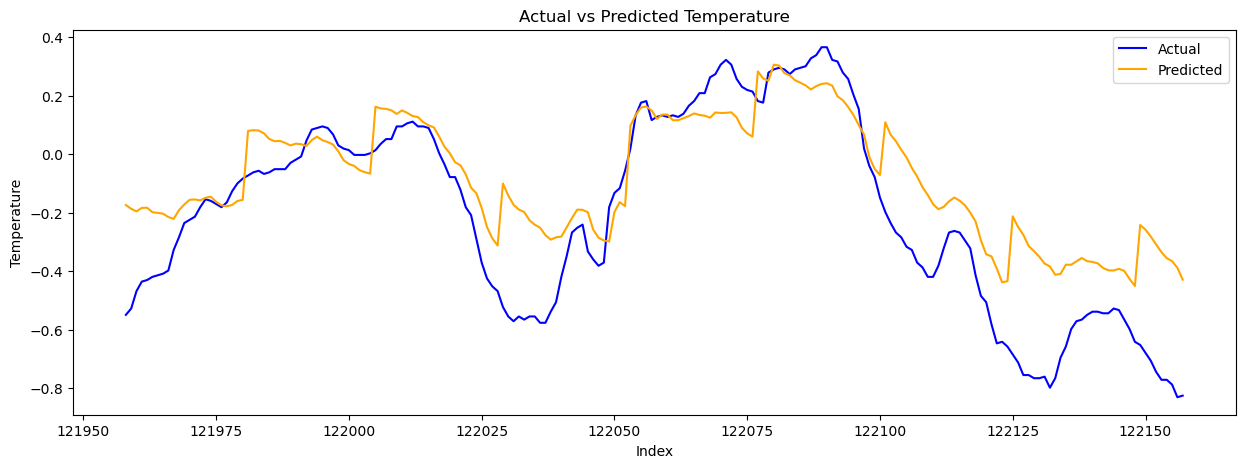

In [105]:
y_pred = model.predict(sm.add_constant(X_test))

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Plot random date range
size = 200
np.random.seed(42)
start_index = np.random.randint(0, len(X_scaled) - size)
random_indices = np.arange(start_index, start_index + size)
X_random = X_scaled.iloc[random_indices]
y_random = y_scaled.iloc[random_indices - forecast_shift]
y_pred_random = model.predict(sm.add_constant(X_random))

# Plot the comparison between predicted and actual values
plt.figure(figsize=(15, 5))
plt.plot(random_indices, y_random.values, label='Actual', color='blue')
plt.plot(random_indices, y_pred_random.values, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

We clearly see that the linear regression model fails to make an accurate 6-hour prediction for the temperature.

### k-Nearest Neighbour

Mean Squared Error: 0.3944250678613882


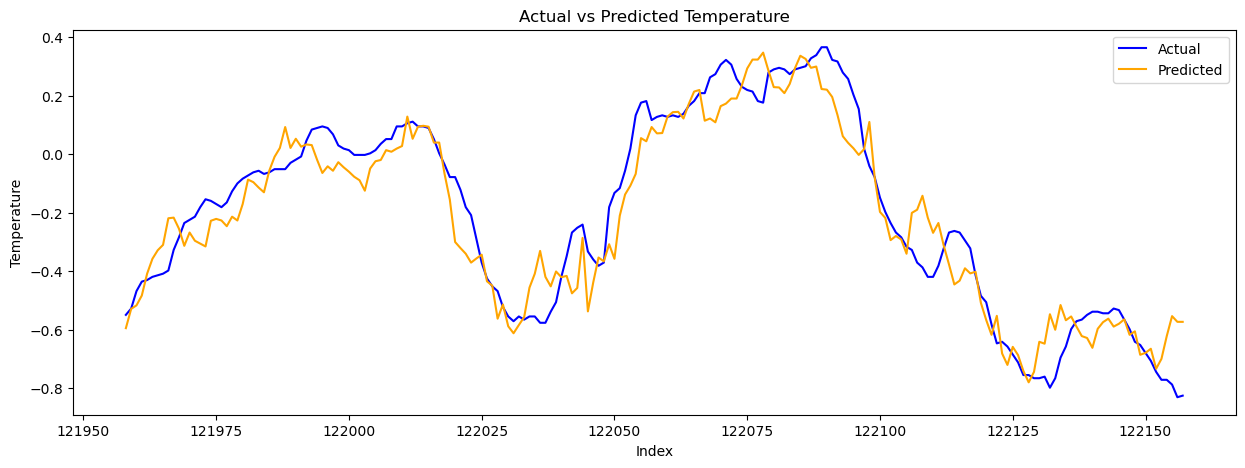

In [106]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot random date range
size = 200
np.random.seed(42)
start_index = np.random.randint(0, len(X_scaled) - size)
random_indices = np.arange(start_index, start_index + size)
X_random = X_scaled.iloc[random_indices]
y_random = y_scaled.iloc[random_indices - forecast_shift]
y_pred_random = knn.predict(X_random)

# Plot the comparison between predicted and actual values
plt.figure(figsize=(15, 5))
plt.plot(random_indices, y_random.values, label='Actual', color='blue')
plt.plot(random_indices, y_pred_random, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

k-Means does a better job, providing a somewhat usable prediction for 6 hours in advance. Does including the humidity information help our prediction?

In [107]:
# add last 10 entries to regression matrix X
lags = 10
forecast_shift = 5
X_b = np.zeros((len(Weather) - lags - forecast_shift, lags))

for i in range(lags, len(Weather) - forecast_shift):
    X_b[i - lags] = Weather['RF_TU'].iloc[i - lags:i].values

X_b = scaler.fit_transform(X_b)

X_scaled_ext = pd.concat([X_scaled, pd.DataFrame(X_b, columns=[f'RF_TU_lag{i}' for i in range(lags, 0, -1)])], axis=1)

X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_scaled_ext, y_scaled, test_size=0.2, random_state=42)

Mean Squared Error: 0.40613999023168385


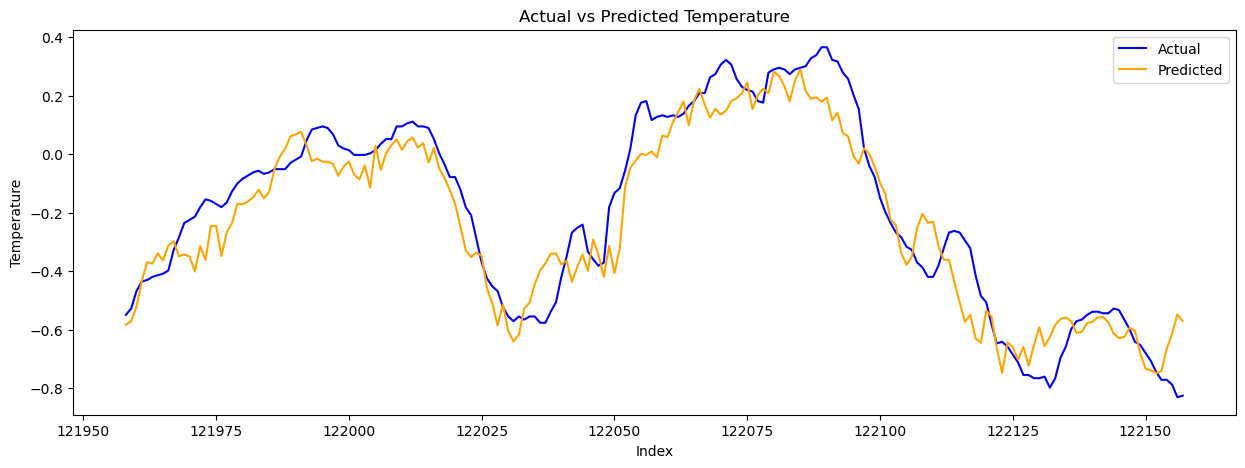

In [108]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_ext, y_train_ext)

y_pred_ext = knn.predict(X_test_ext)

mse = mean_squared_error(y_test_ext, y_pred_ext)
print(f'Mean Squared Error: {mse}')

# Plot random date range
size = 200
np.random.seed(42)
start_index = np.random.randint(0, len(X_scaled_ext) - size)
random_indices = np.arange(start_index, start_index + size)
X_random = X_scaled_ext.iloc[random_indices]
y_random = y_scaled.iloc[random_indices - forecast_shift]
y_pred_random = knn.predict(X_random)

# Plot the comparison between predicted and actual values
plt.figure(figsize=(15, 5))
plt.plot(random_indices, y_random.values, label='Actual', color='blue')
plt.plot(random_indices, y_pred_random, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

Adding humidity information does not seem to improve the temperature prediciton.

## Recurrent Neural Network

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam

To train the Neural Network we need to reshape X to a 3d tensor of form (samples, time steps, features).

In [110]:
timesteps = 10  # as before

# remove the feature 'Hour', since it is only provided once instead of every hour
original_features = X_train.shape[1] - 2
additional_features = 1
total_features = original_features + additional_features

# transform to 3d and add 'Day' data to each time stamp
def include_days_feature(X, timesteps, feature_index):
    expanded_X = np.zeros((X.shape[0], timesteps, total_features))
    for i in range(timesteps):
        expanded_X[:, i, :original_features] = X.iloc[:, :original_features].values
        expanded_X[:, i, original_features:] = X.iloc[:, feature_index].values.reshape(-1, 1)
    return expanded_X

# Reshape data to 3D for GRU model: (samples, timesteps, features)
X_train_reshaped = include_days_feature(X_train, timesteps, -1)
X_test_reshaped = include_days_feature(X_test, timesteps, -1)

Now we build our Recurrent Neural Network using the Gated Recurrent Unit (GRU) architecture.

In [111]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_reshaped, y_train, test_size=0.1, random_state=42)

model = Sequential()
model.add(Input(shape=(timesteps, total_features)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(1))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,501 (37.11 KB)

 Trainable params: 9,501 (37.11 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weather-simple.keras', save_best_only=True)
]

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.8284 - val_loss: 0.5643
Epoch 2/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6901 - val_loss: 0.5579
Epoch 3/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.8602 - val_loss: 0.5566
Epoch 4/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.6857 - val_loss: 0.5899
Epoch 5/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.7216 - val_loss: 0.5762
Epoch 6/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.6496 - val_loss: 0.5721
Epoch 7/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6681 - val_loss: 0.6019
Epoch 8/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.5844 - val_loss: 0.6061
Epoch 9/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.5681 - val_loss: 0.5771
Epoch 10/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.6336 - val_loss: 0.5703
Epoch 11/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.5968 - val_loss: 0.56

4164/4164 ━━━━━━━━━━━━━━━━━━━━ 4s 871us/step
Mean Squared Error: 0.3752163818306391
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


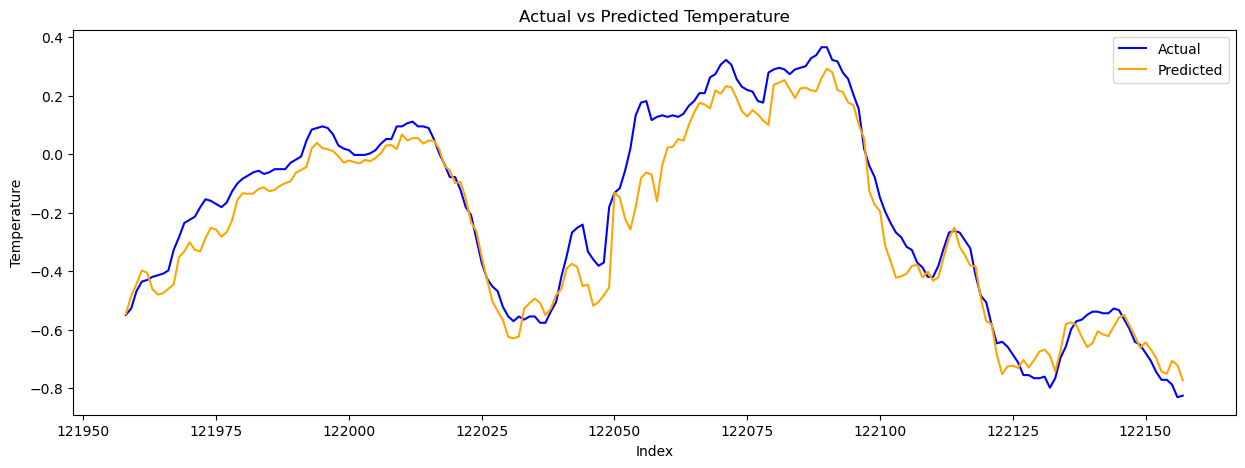

In [113]:
y_pred = model.predict(X_test_reshaped)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the comparison between predicted and actual values for a random sample
size = 200
np.random.seed(42)
start_index = np.random.randint(0, len(X_scaled) - size)
random_indices = np.arange(start_index, start_index + size)

X_random = X_scaled.iloc[random_indices]
y_random = y_scaled.iloc[random_indices - forecast_shift]

# Reshape X_random to 3D for GRU model: (samples, timesteps, features)
X_random_reshaped = include_days_feature(X_random, timesteps, -1)
y_pred_random = model.predict(X_random_reshaped)

plt.figure(figsize=(15, 5))
plt.plot(random_indices, y_random.values, label='Actual', color='blue')
plt.plot(random_indices, y_pred_random.flatten(), label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


So even our very small neural network with less than $10.000$ parameters outperforms our previous regression models. We will now try a slightly more complex model, which has around $32.000$ parameters.

In [124]:
model = Sequential()
model.add(Input(shape=(timesteps, total_features)))
model.add(LSTM(units=50, return_sequences=True))  # First LSTM layer, return sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dense(1))  # Output layer

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,651 (127.54 KB)

 Trainable params: 32,651 (127.54 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weather.keras', save_best_only=True)
]

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.7414 - val_loss: 0.5748
Epoch 2/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.8152 - val_loss: 0.6019
Epoch 3/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.7242 - val_loss: 0.6218
Epoch 4/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.7041 - val_loss: 0.5647
Epoch 5/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.7229 - val_loss: 0.5656
Epoch 6/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.7022 - val_loss: 0.5733
Epoch 7/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.7085 - val_loss: 0.5909
Epoch 8/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.6400 - val_loss: 0.5810
Epoch 9/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.6542 - val_loss: 0.5459
Epoch 10/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.6188 - val_loss: 0.5678
Epoch 11/20
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - loss: 0.5771 - val_loss: 0.56

4164/4164 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Mean Squared Error: 0.37646910131921313
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


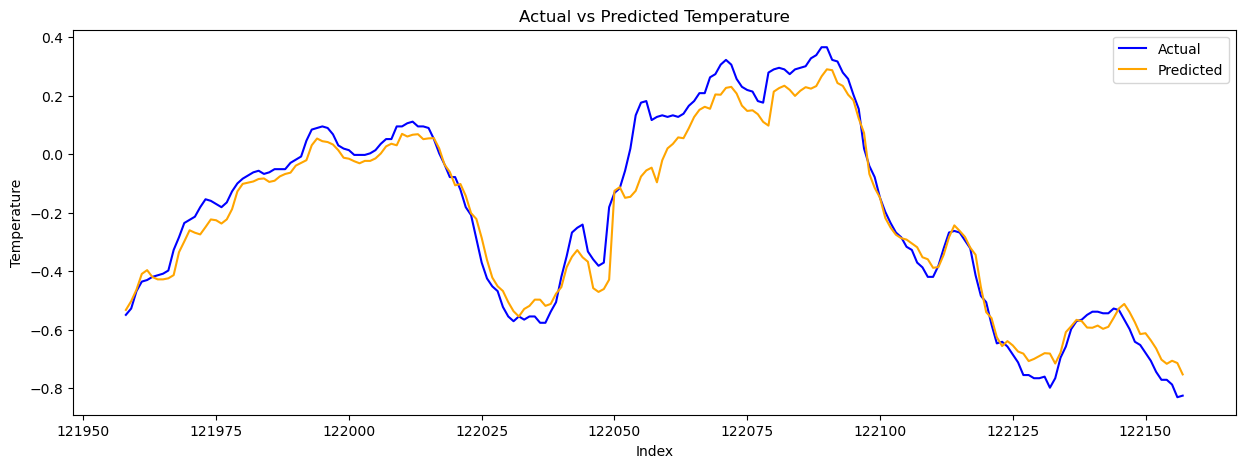

In [126]:
y_pred = model.predict(X_test_reshaped)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the comparison between predicted and actual values for a random sample
size = 200
np.random.seed(42)
start_index = np.random.randint(0, len(X_scaled) - size)
random_indices = np.arange(start_index, start_index + size)

X_random = X_scaled.iloc[random_indices]
y_random = y_scaled.iloc[random_indices - forecast_shift]

# Reshape X_random to 3D for GRU model: (samples, timesteps, features)
X_random_reshaped = include_days_feature(X_random, timesteps, -1)
y_pred_random = model.predict(X_random_reshaped)

plt.figure(figsize=(15, 5))
plt.plot(random_indices, y_random.values, label='Actual', color='blue')
plt.plot(random_indices, y_pred_random.flatten(), label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

Looking at our standard example, the model seems to do a slightly better job. Although in general the mean square error did not decrease significantly.

### Conclusion

In practice, weather predictions are done using far more complicated models taking dozens of different measurement parameters in account. But we could show that a temperature prediction 6 hours ahead is possible using only temperature measurements. We could also demonstrate that even very small Recurrent neural networks outperform classical regression methods at this task.

(c) Mia Müßig